# Init

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from sklearn.metrics import *
from fastai.conv_learner import *
from IPython.display import Image

In [ ]:
PATH = "data/physionet2017/"
arch=resnext50 
sz=224 

In [8]:
label_csv = f'{PATH}REFERENCE-v3.csv'
n = len(list(open(label_csv))) - 1

# Create Validation Data Set

In [9]:
val_idxs = get_cv_idxs(n, val_pct=0.2) # 20% validation
print('n=',n, '\ntrain_size=',n-len(val_idxs), '\nval_size=',len(val_idxs))

n= 8527 
train_size= 6822 
val_size= 1705


# Read Labels

In [10]:
label_df = pd.read_csv(label_csv, header=None, names = ['id', 'rhythm'])
label_df.head()

,id,rhythm
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A


In [11]:
label_df.pivot_table(index='rhythm',aggfunc=len).sort_values('id', ascending=False)

,id
rhythm,
N,5076
O,2415
A,758
~,279


In [12]:
id_and_rhythm = zip(label_df['id'], label_df['rhythm'])
rhythm_by_id = {}
for id, rhythm in id_and_rhythm:
    rhythm_by_id[id] = rhythm

# Initial exploration

In [13]:
def filename_by_id(id): return PATH+'train/'+str(id)+'.jpg'
print(filename_by_id('A00100'))

data/physionet2017/train/A00100.jpg


Id    : A00002 
Rhythm: N


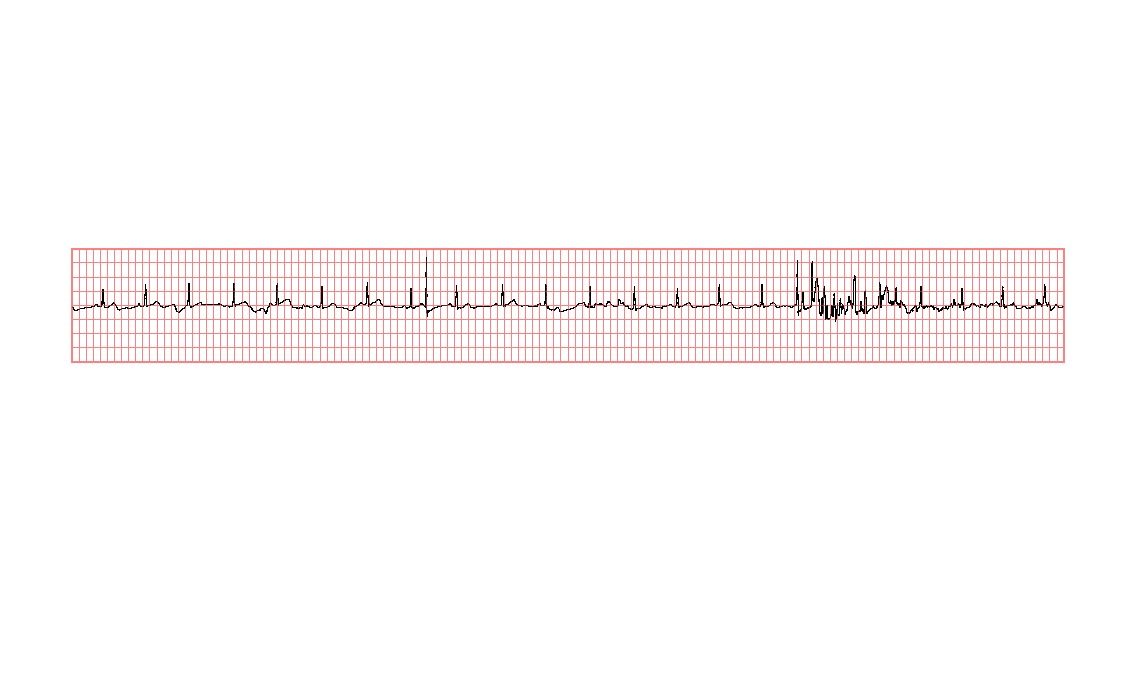

In [14]:
def display_by_id(id):
    print("Id    :", id, "\nRhythm:", rhythm_by_id[id])
    display(Image(filename_by_id(id)))
display_by_id('A00002')

Id    : A03487 
Rhythm: N


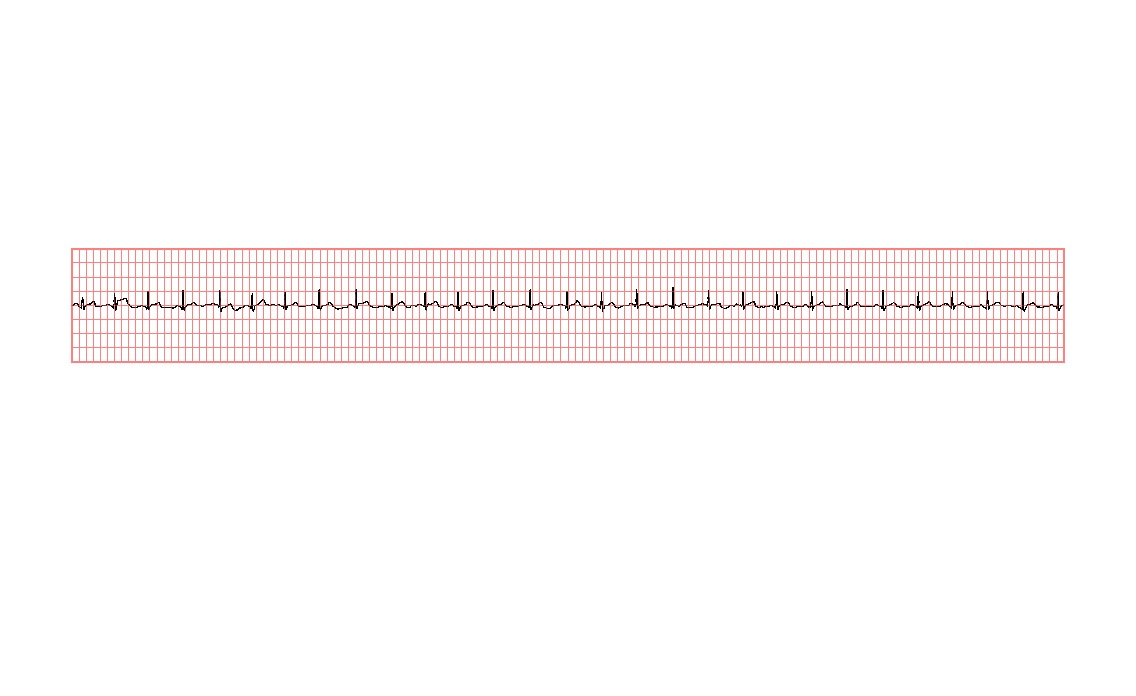

In [15]:
def disply_by_rand():
    r = random.randint(0,n)
    display_by_id(label_df['id'][r])
disply_by_rand()

# Create data + Enable data augmentation

In [16]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [17]:
data = get_data(sz, bs)

In [18]:
print("Train: ", len(data.trn_ds))
print("Val  : ", len(data.val_ds))

Train:  6822
Val  :  1705


# Image Size
note: most imagenet are 224x224 or 229x229 

In [23]:
files = !ls {PATH}train
fn = PATH+'train/'+files[1]
img = PIL.Image.open(fn);
print(fn); img
img.size


data/physionet2017/train/A00002.jpg


(1136, 696)

In [20]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_szz=np.array(row_sz); col_sz=np.array(col_sz)

(array([   0.,    0.,    0.,    0.,    0., 6822.,    0.,    0.,    0.,    0.]),
 array([1135.5, 1135.6, 1135.7, 1135.8, 1135.9, 1136. , 1136.1, 1136.2, 1136.3, 1136.4, 1136.5]),
 <a list of 10 Patch objects>)

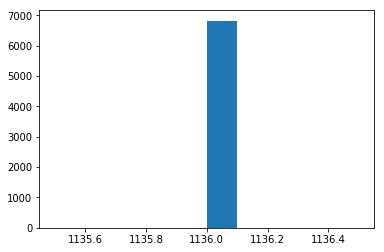

In [21]:
plt.hist(row_sz)

(array([   0.,    0.,    0.,    0.,    0., 6822.,    0.,    0.,    0.,    0.]),
 array([695.5, 695.6, 695.7, 695.8, 695.9, 696. , 696.1, 696.2, 696.3, 696.4, 696.5]),
 <a list of 10 Patch objects>)

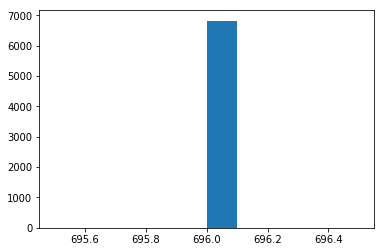

In [22]:
plt.hist(col_sz)

# Find Learning Rate

In [28]:
#learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)
learn = ConvLearner.pretrained(arch, data, ps=0.5, precompute=True) # Original with ps=None

In [29]:
learn

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=4096, out_features=512)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=4)
  (7): LogSoftmax()
)

In [30]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 87%|████████▋ | 93/107 [00:30<00:04,  3.10it/s, loss=7.69]

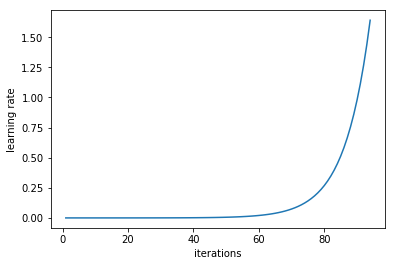

In [21]:
learn.sched.plot_lr()

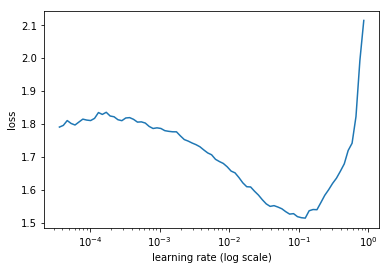

In [22]:
learn.sched.plot()

In [32]:
lr=1e-2

# Initial Model

In [ ]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

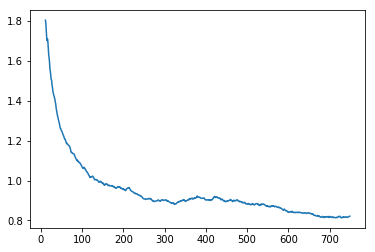

In [25]:
learn.sched.plot_loss()

In [26]:
learn.precompute=False

In [27]:
%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.98038 0.90302 0.59981]                            
[1.      0.98783 0.97337 0.55781]                            
[2.      0.95781 0.9254  0.57788]                            
[3.      0.97771 0.90695 0.61261]                            
[4.      0.96148 0.91755 0.56186]                            
[5.      0.93134 0.87188 0.6155 ]                            
[6.      0.9161  0.89327 0.60226]                            

CPU times: user 7min 46s, sys: 51.3 s, total: 8min 37s
Wall time: 4min 59s


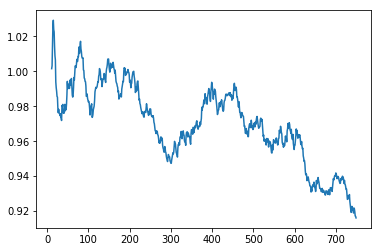

In [28]:
learn.sched.plot_loss()

In [29]:
learn.unfreeze()

In [30]:
lrs=np.array([lr/9,lr/3,lr])

In [31]:
%time learn.fit(lrs, 3, cycle_len=3, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=21), HTML(value='')))

[0.      0.98331 0.85081 0.62617]                            
[1.      0.87942 0.77667 0.66082]                            
[2.      0.81308 0.76779 0.67163]                            
[3.      0.81152 0.78477 0.68082]                            
[4.      0.76673 0.71145 0.71645]                            
[5.      0.72588 0.74047 0.69883]                            
[6.      0.68899 0.6356  0.74469]                            
[7.      0.65718 0.62063 0.75048]                            
[8.      0.63554 0.63341 0.74874]                            
[9.      0.69111 0.66814 0.72784]                            
[10.       0.68679  0.67183  0.738  ]                        
[11.       0.66387  0.62921  0.75041]                        
[12.       0.64271  0.64231  0.7575 ]                        
[13.       0.60883  0.6109   0.75048]                        
[14.       0.60314  0.59132  0.76444]                        
[15.       0.57615  0.58901  0.76907]                        
[16.    

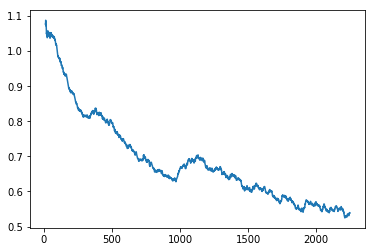

In [32]:
learn.sched.plot_loss()

In [33]:
log_preds, y = learn.TTA()

In [34]:
sklearn.metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds,y)

(0.5326868616903468, 0.7947214076246334)

# Confusion Matrix

Confusion matrix, without normalization
[[116  11  34   1]
 [  5 976  46  12]
 [ 36 170 240  10]
 [  0  19   6  23]]


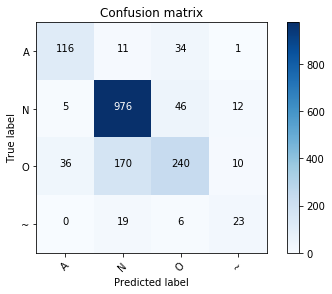

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

In [36]:
sklearn.metrics.f1_score(data.val_y, preds,average=None)

array([0.72727, 0.88126, 0.61381, 0.48936])

In [37]:
sklearn.metrics.f1_score(data.val_y, preds,average='micro') # Accuracy


0.7947214076246334

In [38]:
sklearn.metrics.f1_score(data.val_y, preds,average='macro') # F1 competition score

0.6779273198601277

# Look at mis-classified: Normal classifed as AF

In [39]:
Na = (data.val_y == 1) & (preds == 0)
data.val_ds.fnames[Na]


array(['train/A00765.jpg', 'train/A03276.jpg', 'train/A04344.jpg', 'train/A07782.jpg', 'train/A07874.jpg'],
      dtype='<U16')

Id    : A01165 
Rhythm: N


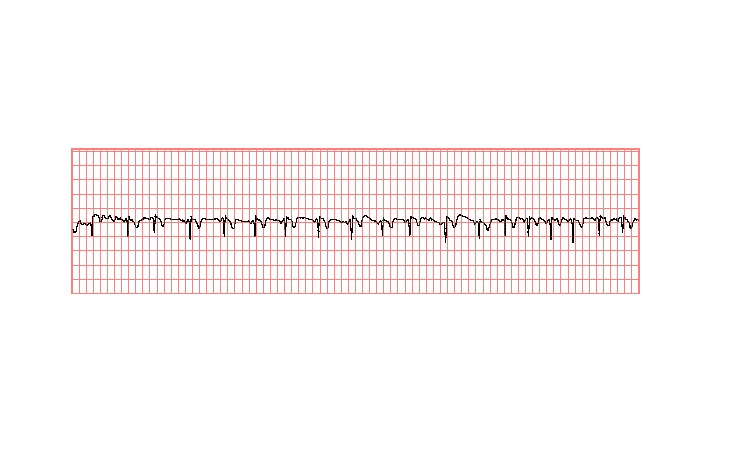

Id    : A01423 
Rhythm: N


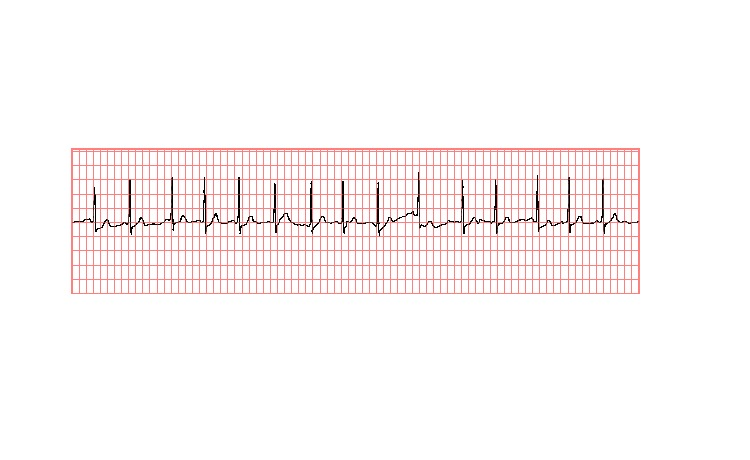

Id    : A01841 
Rhythm: N


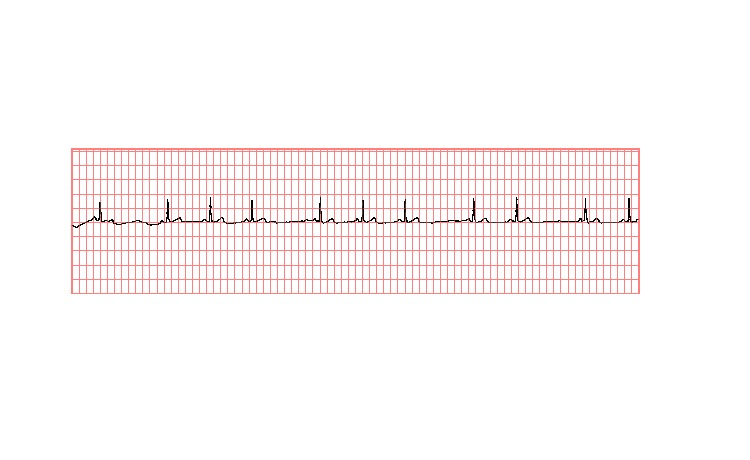

In [40]:
display_by_id('A01165')
display_by_id('A01423')
display_by_id('A01841')

# Look at mis-classified: Noise classifed as Other

In [41]:
No = (data.val_y == 3) & (preds == 2)
data.val_ds.fnames[No]

array(['train/A01503.jpg', 'train/A01917.jpg', 'train/A02133.jpg', 'train/A03934.jpg', 'train/A05822.jpg',
       'train/A08456.jpg'], dtype='<U16')

Id    : A01063 
Rhythm: ~


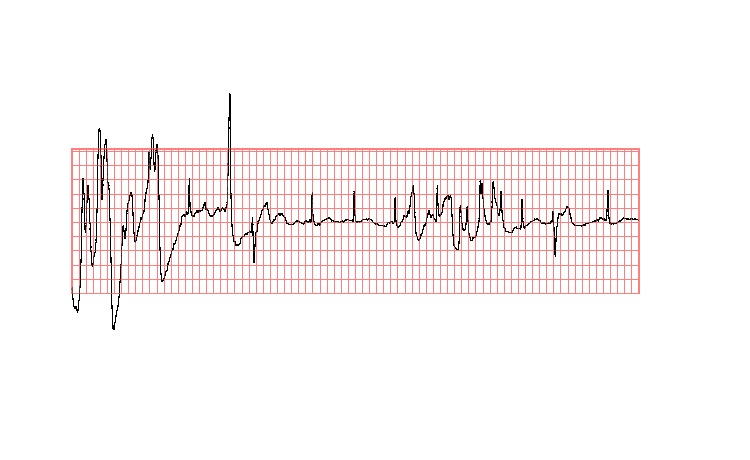

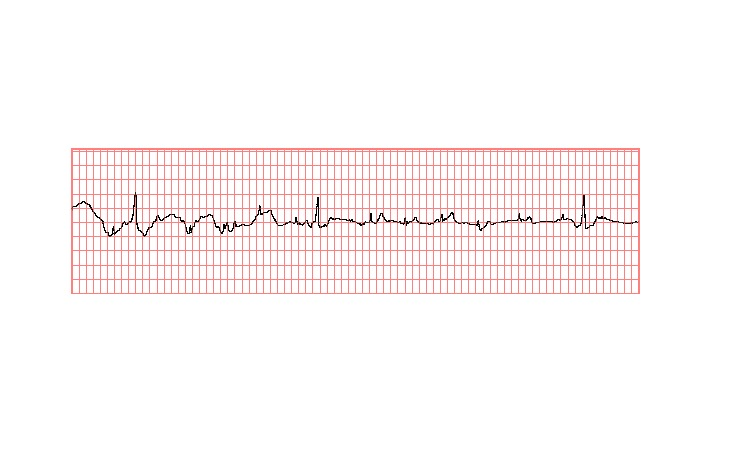

Id    : A01917 
Rhythm: ~
Id    : A02133 
Rhythm: ~


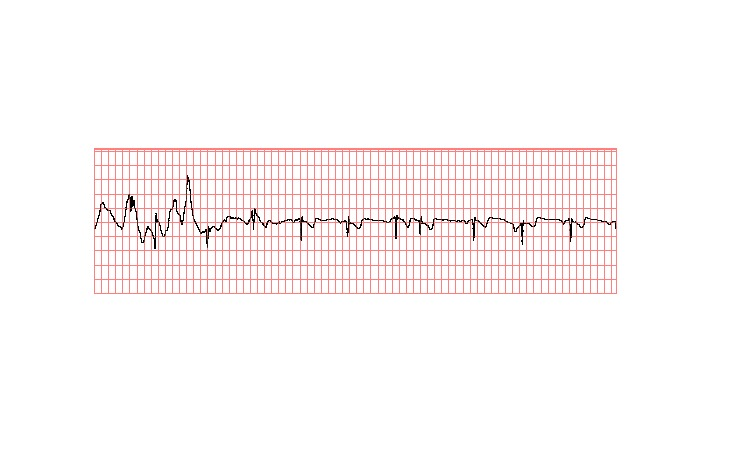

Id    : A05822 
Rhythm: ~


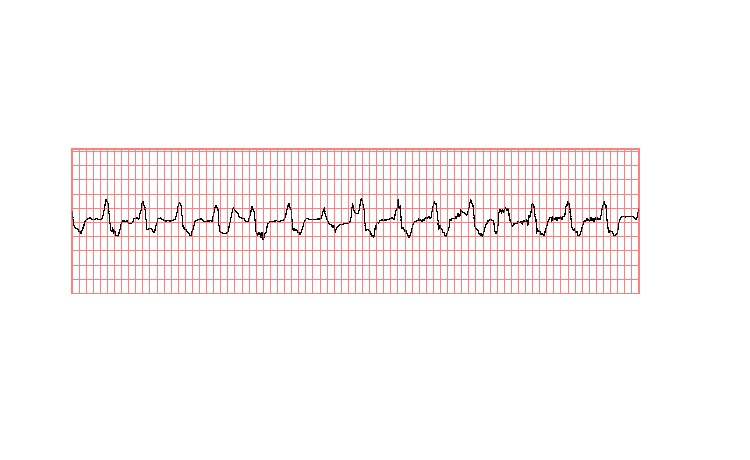

In [42]:
display_by_id('A01063')
display_by_id('A01917')
display_by_id('A02133')
display_by_id('A05822')

# Save

In [43]:
learn.save('Physionet_resnext50_299_32')